# Machine Learning Assignment: Regression Task

In [182]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid', color_codes = True)

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, normalize, scale, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

#### จะพยายามแบ่งการทำ Model เป็น 3 model ใหญ่ๆคือ ARIMA, Regression และ Dynamic Regression

## Data Import

เลือกใช้ data จากภายนอกเพราะว่าต้องการค่าที่เป็นเวลาที่จริงขึ้น และสามารถนำข้อมูลอื่นๆ มาใช้ในการ Analysis และใช้ในการสร้าง model ชนิดอื่นด้วยโดย data ที่ได้เป็น data ที่ได้มาจากการ query ใน google bigquery โดยเลือกใช้ประเทศเป็น UK

In [2]:
df = pd.read_csv('UK_results-20200503-150942.csv') # from bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide

#### Split data into train and test

In [69]:
# df_res is train data
df_res = df[:118]
# df_test is test data
df_test = df[118:].reset_index(drop = True)

In [68]:
df_test

,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,countries_and_territories,geo_id,country_territory_code,pop_data_2018
0,2020-04-27,27,4,2020,4463,420,152840,24055,United_Kingdom,UK,GBR,66488991
1,2020-04-28,28,4,2020,4309,338,157149,24393,United_Kingdom,UK,GBR,66488991
2,2020-04-29,29,4,2020,3996,909,161145,25302,United_Kingdom,UK,GBR,66488991
3,2020-04-30,30,4,2020,4076,795,165221,26097,United_Kingdom,UK,GBR,66488991
4,2020-05-01,1,5,2020,6032,674,171253,26771,United_Kingdom,UK,GBR,66488991
5,2020-05-02,2,5,2020,6201,739,177454,27510,United_Kingdom,UK,GBR,66488991
6,2020-05-03,3,5,2020,4806,621,182260,28131,United_Kingdom,UK,GBR,66488991
7,2020-05-04,4,5,2020,4339,315,186599,28446,United_Kingdom,UK,GBR,66488991
8,2020-05-05,5,5,2020,3985,288,190584,28734,United_Kingdom,UK,GBR,66488991
9,2020-05-06,6,5,2020,4406,693,194990,29427,United_Kingdom,UK,GBR,66488991


In [70]:
df_test2 = df_test.copy()

# 1. ARIMA Model
เนื่องจาก ARIMA Model เป็น model ที่เป็น time series เลยจะใช้แค่ df_res ก่อนแล้วมาดู correlation ในตัว data อีกที

In [6]:
# Safety first
df_res2 = df_res.copy()

In [7]:
df_res = df_res2.copy()

In [8]:
# Set date column into index
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)

In [9]:
# slice dataframe because we use time series model so it only need 1 columns (of independent variables)
df_res = df_res.iloc[:, 3]
df_res.head(3)

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
Name: daily_confirmed_cases, dtype: int64

In [10]:
df_res.tail()

date
2020-04-22    4301
2020-04-23    4451
2020-04-24    4583
2020-04-25    5386
2020-04-26    4913
Name: daily_confirmed_cases, dtype: int64

Text(0, 0.5, 'Amount')

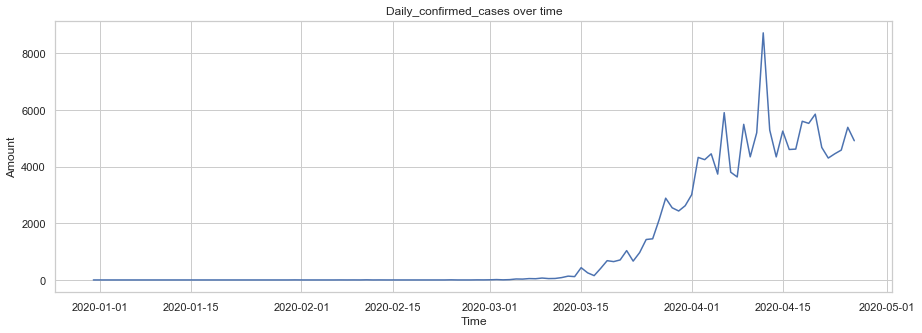

In [11]:
# Observed Daily confirmed Cases
plt.figure(figsize=(15, 5))
plt.plot(df_res)
plt.title('Daily_confirmed_cases over time')
plt.xlabel('Time')
plt.ylabel('Amount')

<hr>
<br>


# Might use for testing

<br>
<hr>

ดู Autocorrelation ใน daily change ในแต่ละวัน

In [12]:
daily_diff = df_res.diff()
daily_diff = daily_diff.dropna()
# Compute autocorrelation of daily different of confirmed cases
autocorr_daily = daily_diff.autocorr()
print("The autocorrelation of daily confirmed cases\
 is %4.2f" %(autocorr_daily))

The autocorrelation of daily confirmed cases is -0.34


ค่อนข้างส่งผลต่อค่าในวันถัดๆไป แต่ยังไงก็ต้องมาดู Autocorrelation function ว่า lags เก่าๆ(ค่าวันเก่า)มีผลทางตรงและทางอ้อมต่อวันต่อๆไปยังไงบ้าง

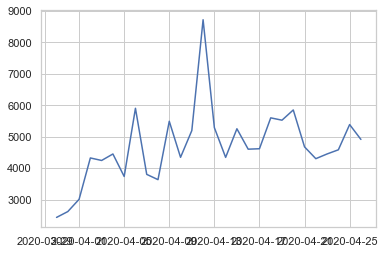

In [13]:
# plot to see if the confirmed cases is always up (check if it not cumulative)
plt.plot(df_res[90:])

C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


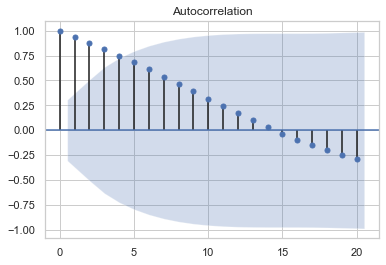

In [14]:
# define only 20 lags for plot and 95 % confidence interval
df_res_acf = acf(df_res)
plot_acf(df_res_acf, lags = 20, alpha = 0.05)
plt.show()

### Check if the data is Stationarity

ตรวจดูว่าข้อมูล Time Series ของเราเป็น Stationarity หรือเปล่า

In [15]:
result = adfuller(df_res)

print(f'ADF StatisticL {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF StatisticL -1.805690181044707
p-value: 0.3776403585750923
Critical Values:
	1%: -3.492995948509562
	5%: -2.888954648057252
	10%: -2.58139291903223


สังเกตุที่ค่า p value หาก p value ที่ได้ > 0.05 หรือมากกว่าค่าความเชื่อมั่นที่ตั้งไว้ (95%) ก็จะถือว่าเป็นข้อมูลที่เป็น Non stationarity

เนื่องจากข้อมูลเป็น Non stationarity อาจจะทำให้การสร้าง ARIMA Model ทำนายออกมาได้ไม่ดี จึงลองใช้ differencing จากข้อมูลในสันก่อนหน้านี้ และนำมาทำ AR Model ก่อน

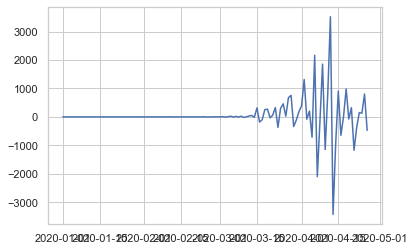

In [16]:
# Do AR Model and estimate order parameter
# First check if it still trend shape
daily_diff = df_res.diff(periods=1)
daily_diff = daily_diff.dropna()
plt.plot(daily_diff)

สังเกตุได้ว่ามีข้อมูลที่เป็น nan เยอะเพราะช่วงวันแรกๆ ไม่มีผู้ติดเชื้อ diff เลยเป็น 0 จึงลองเพิ่ม period ของ difference ดู

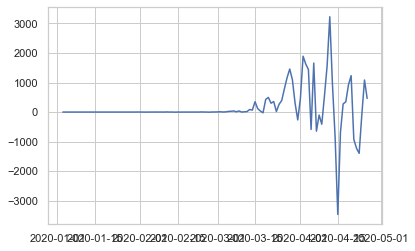

In [17]:
daily_diff = df_res.diff(periods=3)
daily_diff = daily_diff.dropna()
plt.plot(daily_diff)

พบว่าไม่เปลี่ยนแปลงไปจากเดิมมาก จึงขอใช้ period = 1

In [18]:
daily_diff = df_res.diff(periods=1).dropna()

#### AR Model
estimate order of model using Bayesian Information Criterion (BIC)

C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\theka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\theka\

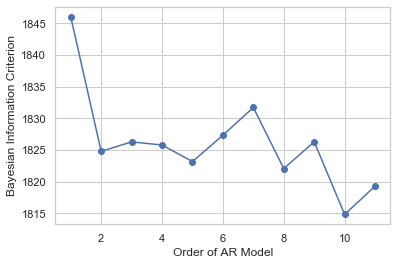

In [19]:
BIC = np.zeros(12
              )
for p in range(12):
    model = ARMA(daily_diff, order = (p, 0))
    result = model.fit()
    # Save BIC for each AR
    BIC[p] = result.bic

plt.plot(range(1,12), BIC[1:12], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()
warnings.filterwarnings('ignore')

look like 10 order from BIC in AR Model is good enogh but if I used 10 as p order this will result in being not stationarity time series data so I must use only 7

#### MA Model
estimate order of MA Model using Autoregressive Function โดยใช้การประมาณจากการ plot autoregressive ก่อนหน้านี้

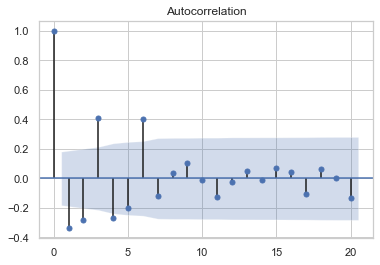

In [20]:
plot_acf(daily_diff, lags = 20)
plt.show()

จากการนับค่าที่เกิน confidence value มาแล้วนับได้ 6 ค่าเห็นจะได้(เกิน max conf) ก็จะลองนำไปทำ MA Model

### แต่
พอลองนำไปเข้า MA Model กลับ error เลยใช้ q orders ได้สูงสุดแค่ 5

In [21]:
model = ARMA(daily_diff, order=(0, 5))
result = model.fit()
print(result.summary())

                                ARMA Model Results                               
Dep. Variable:     daily_confirmed_cases   No. Observations:                  117
Model:                        ARMA(0, 5)   Log Likelihood                -898.158
Method:                          css-mle   S.D. of innovations            505.052
Date:                   Thu, 07 May 2020   AIC                           1810.315
Time:                           01:55:19   BIC                           1829.651
Sample:                       01-01-2020   HQIC                          1818.165
                            - 04-26-2020                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          36.2521     21.787      1.664      0.096      -6.449      78.953
ma.L1.daily_confirmed_cases    -0.9690      0.070    -13

In [22]:
print(result.params)

const                          36.252143
ma.L1.daily_confirmed_cases    -0.969002
ma.L2.daily_confirmed_cases     0.098027
ma.L3.daily_confirmed_cases     0.118020
ma.L4.daily_confirmed_cases    -0.368441
ma.L5.daily_confirmed_cases     0.595467
dtype: float64


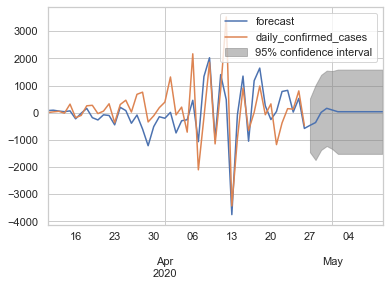

In [23]:
# Try forecast using MA Model
result.plot_predict(start = 70, end = 130)
plt.show()

### Lets do some ARMA model

(4, 5) 1797 <br>
(10, 2) 1785 <br>
(11, 1) 1783 <br>
(11, 2) 1781 <br>
(12, 2) 1782 <br>
(12, 3) 1784

In [24]:
mod_arma1 = ARMA(daily_diff, order = (11, 2))
res_arma1 = mod_arma1.fit()
print(f'The AIC for an AR order (11, 2) is : {res_arma1.aic}')

The AIC for an AR order (11, 2) is : 1781.5635378747802


### ARIMA RESULT

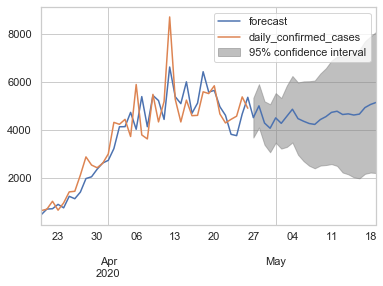

In [25]:
model_ari2 = ARIMA(df_res, order = (11, 1, 2))
res_ari2 = model_ari2.fit()

res_ari2.plot_predict(start = 80, end = 140)
plt.show()

<hr>

# 2. Regression model

ในการทำ Regression ได้เลือกใช้ข้อมูลที่มากกว่าเดิมโดยเป็นข้อมูล mobility ช่วงที่มีเหตุ Covid 19 เพราะข้อมูล mobility เป็นข้อมูลที่บ่งบอกเรื่องการเคลื่อนย้ายขนส่งหรือเดินทางได้เป็นอย่างดี จึงอาจมีส่วนช่วยในการทำนายค่าของคนที่เป็น COVID-19

In [26]:
df_mob = pd.read_csv('UK_mobility_results-20200503-152437.csv') # from bigquery-public-data.covid19_google_mobility.mobility_report

#### df_mob description 
This dataset aims to provide insights into what has changed in response to policies aimed at combating COVID-19. It reports movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

This dataset is intended to help remediate the impact of COVID-19. It shouldn’t be used for medical diagnostic, prognostic, or treatment purposes. It also isn’t intended to be used for guidance on personal travel plans. <br>
More at: https://www.google.com/covid19/mobility/data_documentation.html


### df_mob exploration

In [27]:
# Set index to date and change it to datetime
df_mob = df_mob.set_index(['date'])
df_mob.index = pd.to_datetime(df_mob.index)

In [28]:
df_mob.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,
2020-04-02,GB,United Kingdom,NaN,NaN,-75.0,-32.0,-24.0,-73.0,-70.0,29.0
2020-04-03,GB,United Kingdom,NaN,NaN,-76.0,-30.0,-25.0,-72.0,-69.0,29.0


Check to see when the data is started

In [29]:
# I will group by the date
df_mob2 = df_mob.groupby('date').mean()
df_mob2.head(2)

,sub_region_2,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,
2020-02-15,NaN,-11.309211,-5.743421,-36.874074,-12.534247,-3.892617,2.433628
2020-02-16,NaN,-5.979866,-4.516779,-24.661654,-6.248227,-2.594595,1.139535


In [30]:
df_res.head(2)

date
2019-12-31    0
2020-01-01    0
Name: daily_confirmed_cases, dtype: int64

เหมือนว่าช่วงเวลาของข้อมูลจะไม่ตรงกัน เลยอาจจะใช้แค่ข้อมูล df_res เพียงอย่างเดียว

#### Correlation between all variables

In [31]:
# Back in using old df_res
df_res = df_res2.copy()
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)
df_res = df_res.iloc[:, 3:7]

df_res_change = df_res.pct_change()
df_res_change
# At first there might be some 0 data row because there are not
# much infected appear

,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths
date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-04-22,-0.080197,1.096601,0.034479,0.061519
2020-04-23,0.034876,-0.285836,0.034492,0.041389
2020-04-24,0.029656,-0.131422,0.034331,0.034520


เลือกใช้ที่เป็น percentage change เพราะใช้บอกความสัมพันธ์ระหว่างการเปลี่ยนแปลงได้ดีกว่าแบบปกติ

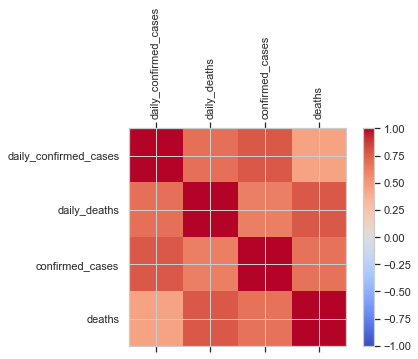

In [32]:
corr = df_res_change.corr()
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_res_change.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation = 90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_res_change.columns)
ax.set_yticklabels(df_res_change.columns)
plt.show()
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

เหมือนว่าจะมีความสัมพันธ์เป็นไปในเชิงบวกเยอะ งั้นเดี๋ยวลองทำ scatter plot ดู

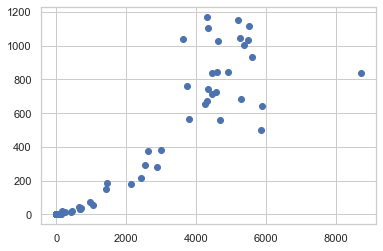

In [33]:
plt.scatter(df_res.daily_confirmed_cases, df_res.daily_deaths)

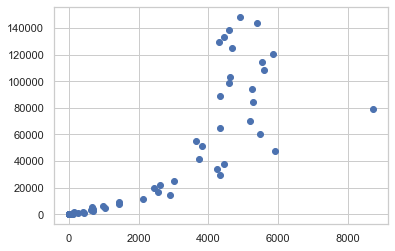

In [34]:
plt.scatter(df_res.daily_confirmed_cases, df_res.confirmed_cases)

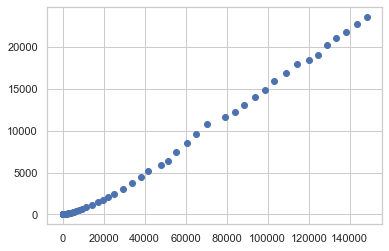

In [35]:
plt.scatter(df_res.confirmed_cases, df_res.deaths)

มีความสัมพันธ์กันในเชิงบวกเป็นจำนวนมาก จึงลองทำ LinearRegression ดูแบบคร่าวๆก่อน

### Regression Model 1

Define features building funtion becuase I split data into two set up there (ARIMA Model) so it will be messy if im not defining new function to create feature itself

#### Here is original data columns <br>
['date', 'day', 'month', 'year', 'daily_confirmed_cases', 'daily_deaths',
       'confirmed_cases', 'deaths', 'countries_and_territories', 'geo_id',
       'country_territory_code', 'pop_data_2018']

### Feature Engineering

ตรงการสร้าง features นี้จะลบ featuresที่เป็น confirmed cases และ daily confirmed cases ไปด้วยเพราะโกงไป

In [36]:
def add_feat(df):
    
    df.date = pd.to_datetime(df.date)
    df['inter_t'] = df.date.apply(lambda x: x.toordinal())
        
    # back at normal features
    c_cases = df.daily_confirmed_cases.values
    n_list = ['t-1', 't-2']
    df2 = df
    #df2 = 
    df2 = df2.drop(np.arange(2)).reset_index(drop = True)
    for i in range(2)[::-1]:
        df2[n_list[-i + 1]] = c_cases[i: i - 2]
        
    #for percentage change part
    df_change = df2.iloc[:, [0, 5, 7, 9, 10]]
    df_change = df_change.set_index(['date'])
    df_change = df_change.pct_change()
    df_change = df_change.fillna(0)
    
    df2 = df2.drop(columns = ['date', 'daily_confirmed_cases', 'confirmed_cases'])
    ser1 = np.array(df2.values)
    ser2 = np.array(df_change.values)
    ser3 = np.hstack((ser1, ser2))
    return ser3

In [71]:
# Retrieve data
df_res = df_res2.copy()
df_res = df_res.iloc[:, :8]

df_test = df_test2.copy()
df_test = df_test.iloc[:, :8]

Now I need to write function to retrive label data and store it in y variables

In [87]:
def label_y(df):
    df = df.drop(np.arange(2)).reset_index(drop = True)
    y = df.iloc[:, 4].values
    return y.reshape((-1, 1))

In [171]:
df_test[:5]

,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,inter_t
0,2020-04-27,27,4,2020,4463,420,152840,24055,737542
1,2020-04-28,28,4,2020,4309,338,157149,24393,737543
2,2020-04-29,29,4,2020,3996,909,161145,25302,737544
3,2020-04-30,30,4,2020,4076,795,165221,26097,737545
4,2020-05-01,1,5,2020,6032,674,171253,26771,737546


### Data Preparation

In [88]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

#### Shape print

In [89]:
print(X_train.shape, X_test.shape)

(116, 12) (8, 12)


In [90]:
print(y_train.shape, y_test.shape)

(116, 1) (8, 1)


Check if there is still NaN or Inf value before input data into training

In [115]:
np.isinf(X_train).any()

True

In [121]:
ar_inf = np.where(np.isinf(X_train))
print(ar_inf)

(array([30, 31, 37, 38, 39, 40, 41, 42, 43, 44, 54, 55, 58, 59, 65, 65, 68,
       71], dtype=int64), array([10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11,  8,  9,  8,
        8], dtype=int64))


In [128]:
# set them to zero
X_train[X_train == np.inf] = 0

In [129]:
np.isinf(X_train).any()

False

In [130]:
X_train.shape

(116, 12)

### Modeling

In [165]:
model = LinearRegression().fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [166]:
mean_absolute_error(y_test, y_pred1)

610.0306590385735

เนื่องจากต้องการ metrics ที่เหมาะสมในการทำนายมากกว่านี้ (MAPE) จึงขอเขียน function MAPE <br>
https://www.statisticshowto.com/mean-absolute-percentage-error-mape/

In [167]:
def MAPE(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [168]:
MAPE(y_test, y_pred1)

12.035726734779276

เพราะจากการทำ feature engineering data เลยถูกลบออกไป 2 rows

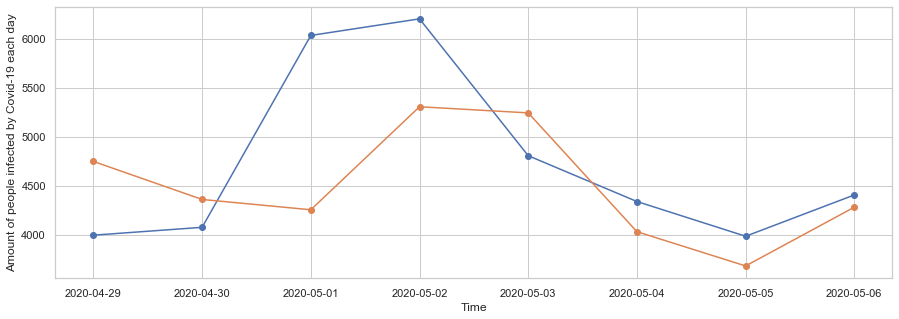

In [169]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred1, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

### Polynomial 2 degrees

In [152]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X_train)
    
model = LinearRegression().fit(X_poly, y_train)
pred = model.predict(poly.fit_transform(X_test))

In [158]:
X_poly.shape

(116, 91)

In [156]:
y_test

array([[3996],
       [4076],
       [6032],
       [6201],
       [4806],
       [4339],
       [3985],
       [4406]], dtype=int64)

In [153]:
pred

array([[ -97981.58886719],
       [  -5754.19287109],
       [1495818.42626953],
       [1535793.78173828],
       [1574346.49511719],
       [1596753.31787109],
       [1605987.77148438],
       [1626730.57617188]])

In [159]:
MAPE(y_test, pred)

24817.210178251746

#### สรุปผลการทำ Polynomial Degree = 2 

ณ ตอนนี้ไม่ควรทำ Polynomial เพราะว่าจะทำให้จำนวนของ sample data < features ที่ใช้ แล้วจะได้ผลที่มี error เยอะจึงไม่มีการทำ polynomial features ต่อ

### Regression Model 2

#### Normalize data features

In [170]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [173]:
model = LinearRegression().fit(X_train, y_train)
y_pred2 = model.predict(X_test)

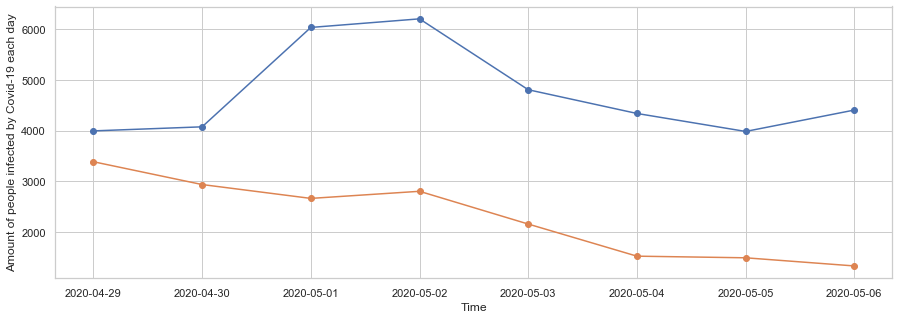

In [174]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred2, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [175]:
MAPE(y_test, y_pred2)

50.66839207610778

#### Standardize data

In [177]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [178]:
X_train = scale(X_train)
X_test = scale(X_test)

In [179]:
model = LinearRegression().fit(X_train, y_train)
y_pred3 = model.predict(X_test)

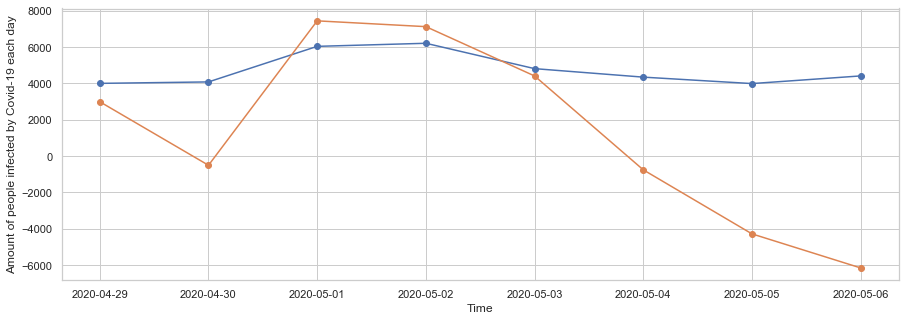

In [180]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred3, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [194]:
MAPE(y_test, y_pred3)

93.60487356936946

#### Min-Max Scaler

In [183]:
min_max_scaler = MinMaxScaler()

In [187]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [188]:
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

In [189]:
model = LinearRegression().fit(X_train, y_train)
y_pred4 = model.predict(X_test)

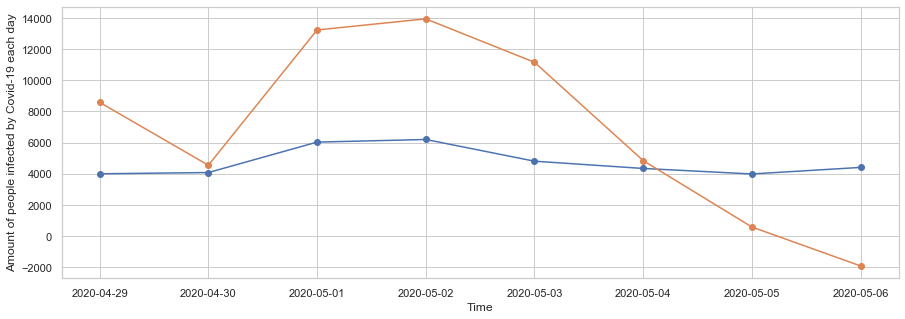

In [190]:
plt.figure(figsize = (15, 5))
plt.plot(df_test.drop(np.arange(2)).date, y_test, marker = 'o')
plt.plot(df_test.drop(np.arange(2)).date, y_pred4, marker = 'o')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [192]:
MAPE(y_test, y_pred4)

93.0106573194747

### สรุปผล regresssion

ณ ตอนนี้ยังสรุปผลไม่ได้มากว่า Normalize หรือปรับ scale ต่างๆบนข้อมูลจะมีผลต่อผลลัพธ์จากการทำนายหรือไม่ เพราะข้อมูลในขณะนี้ มีน้อยมากๆ จึงวัดผลลัพธ์ที่แน่นอนจากการ test ได้ยาก

<hr>

#### Test on Train data

In [195]:
X_train = add_feat(df_res)
X_test = add_feat(df_test)
y_train = label_y(df_res)
y_test = label_y(df_test)

# set inf value to zero
X_train[X_train == np.inf] = 0

In [196]:
model = LinearRegression().fit(X_train, y_train)
y_pred5 = model.predict(X_train)

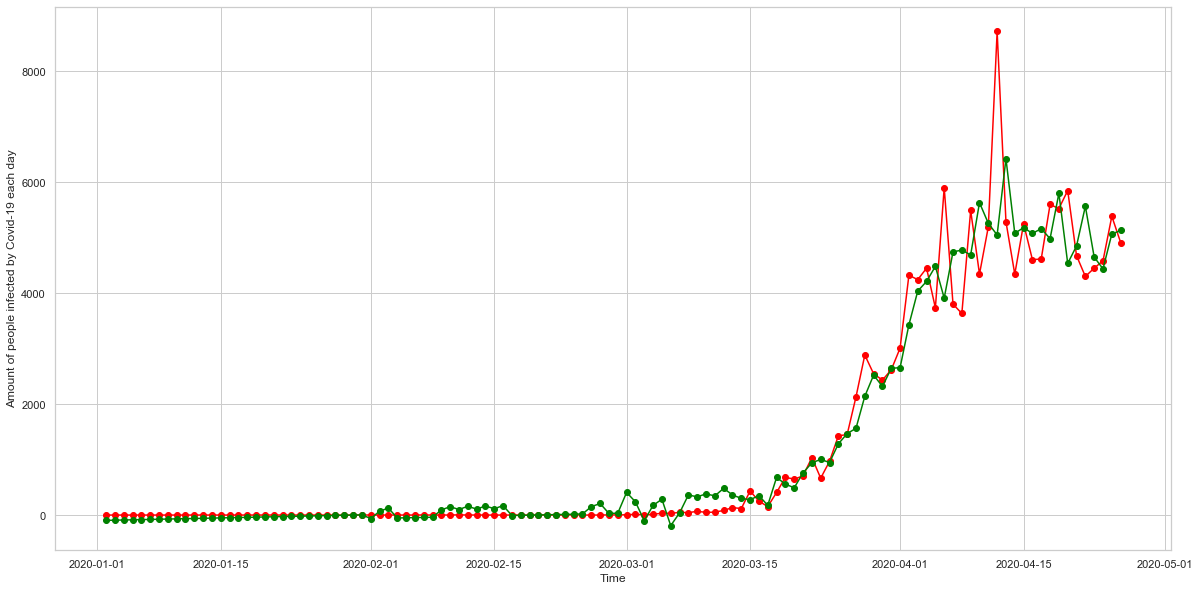

In [201]:
plt.figure(figsize = (20, 10))
plt.plot(df_res.drop(np.arange(2)).date, y_train, marker = 'o', c = 'red')
plt.plot(df_res.drop(np.arange(2)).date, y_pred5, marker = 'o', c = 'green')
plt.xlabel('Time')
plt.ylabel('Amount of people infected by Covid-19 each day')
plt.show()

In [203]:
mean_absolute_error(y_train, y_pred5)

255.47050488637439